| Name               | Roll Number  |
|--------------------|--------------|
| Usman Faizyab Khan | CS-22076     |
| Syed Abdul Basit   | CS-22089     |


In [221]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import ipywidgets as widgets
from IPython.display import display, Markdown, HTML, clear_output

In [222]:
def display_grid_search_results(grid, X_test, y_test, label_names):

    # Results DataFrame
    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by='mean_test_score', ascending=False)

    # Identify param columns dynamically
    param_cols = [col for col in results_df.columns if col.startswith('param_')]

    # Display top results
    display(Markdown("### Grid Search Results"))
    display_cols = param_cols + ['mean_test_score', 'std_test_score']
    display(results_df[display_cols].style.hide(axis="index"))

    # Only show heatmap if exactly 2 param columns
    if len(param_cols) == 2:
        pivot_table = results_df.pivot(index=param_cols[0], columns=param_cols[1], values='mean_test_score')
        plt.figure(figsize=(5, 4))
        sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
        plt.title("Mean Test Accuracy")
        plt.xlabel(param_cols[1])
        plt.ylabel(param_cols[0])
        plt.tight_layout()
        plt.show()

    # Best model parameters
    best_model_data = grid.best_params_.copy()
    best_model_data['mean_test_score'] = f"{grid.best_score_:.4f}"
    best_model_row_df = pd.DataFrame(best_model_data.items(), columns=['Attribute', 'Value'])

    display(Markdown("### Best Model Parameters"))
    display(best_model_row_df.style.hide(axis="index"))

    # Predictions on test set
    y_pred = grid.predict(X_test)

    # Classification report
    report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=label_names)
    report_df = pd.DataFrame(report_dict).transpose().round(3)

    display(Markdown("### Classification Report"))
    display(report_df)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=label_names, yticklabels=label_names,
                linewidths=0.5, linecolor='gray', square=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.tight_layout()
    plt.show()

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    display(Markdown(f"### Accuracy on Test Set: `{acc:.4f}`"))


In [223]:

def preprocess_user_input(df):
    df[columns_to_standardize] = standard_scaler.transform(df[columns_to_standardize])
    
    df = pd.get_dummies(df, columns=['Precip Type'])
    
    for col in final_columns:
        if col not in df.columns:
            df[col] = 0
            
    df = df[final_columns]    
    return df


def predict_weather(model, preprocess_fn=preprocess_user_input):
    display(HTML("""
    <style>
    .widget-label {
        text-align: left !important;
        min-width: 160px;
    }
    </style>
    """))

    # Layout and style
    widget_layout = widgets.Layout(width='350px', margin='0 0 10px 0')
    desc_style = {'description_width': 'initial'}

    # Input widgets
    temperature = widgets.FloatText(description='Temperature (C):', layout=widget_layout, style=desc_style)
    wind_speed = widgets.FloatText(description='Wind Speed (km/h):', layout=widget_layout, style=desc_style)
    visibility = widgets.FloatText(description='Visibility (km):', layout=widget_layout, style=desc_style)
    pressure = widgets.FloatText(description='Pressure (millibars):', layout=widget_layout, style=desc_style)
    humidity = widgets.FloatText(description='Humidity:', layout=widget_layout, style=desc_style)
    wind_bearing = widgets.FloatText(description='Wind Bearing (degrees):', layout=widget_layout, style=desc_style)
    precip_type = widgets.Dropdown(options=['None', 'Rain', 'Snow'], description='Precip Type:', layout=widget_layout, style=desc_style)
    date = widgets.DatePicker(description='Date:', layout=widget_layout, style=desc_style)
    

    # Predict button
    button = widgets.Button(description="Predict", layout=widgets.Layout(width='150px'))
    output = widgets.Output()

    def on_button_clicked(b):
        with output:
            clear_output()
            try:
                user_date = date.value
                if user_date is None:
                    raise ValueError("Please select a date.")
                
                user_df = pd.DataFrame({
                    "Temperature (C)": [temperature.value],
                    "Wind Speed (km/h)": [wind_speed.value],
                    "Visibility (km)": [visibility.value],
                    "Pressure (millibars)": [pressure.value],
                    "Humidity": [humidity.value],
                    "Wind Bearing (degrees)": [wind_bearing.value],
                    "Precip Type": [precip_type.value],
                    "Month": [user_date.month],
                    "Day": [user_date.day]
                })
                processed = preprocess_fn(user_df)

                try:
                    # For Keras models
                    prob = model.predict(processed)[0]
                    pred_class = np.argmax(prob)
                except:
                    # For sklearn models
                    pred_class = model.predict(processed.values)[0]

                display(HTML(f"<h4>🌤️ Predicted Class: <span style='color:green'>{label_names[pred_class]}</span></h4>"))
            except Exception as e:
                display(HTML(f"<b style='color:red'>❌ Error: {str(e)}</b>"))



    button.on_click(on_button_clicked)

    # Heading
    heading = widgets.HTML("<h2 style='margin-bottom:10px; margin-left:40px;'>🌦️ Weather Prediction Tool</h2>")

    # Button container for centering
    button_box = widgets.HBox([button], layout=widgets.Layout(margin='0 0 0 100px'))

    # Display all
    display(widgets.VBox([
        heading,
        temperature, wind_speed, visibility, pressure,
        humidity, wind_bearing, precip_type, date,
        button_box,
        output
    ]))

In [224]:
results = []

In [225]:
# Load dataset
weather_dataset = pd.read_csv('weatherHistory.csv')

# Data Preprocessing

In [226]:
weather_dataset.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [227]:
weather_dataset["Daily Summary"].unique()

array(['Partly cloudy throughout the day.',
       'Mostly cloudy throughout the day.', 'Foggy in the evening.',
       'Foggy overnight and breezy in the morning.',
       'Overcast throughout the day.', 'Partly cloudy until night.',
       'Mostly cloudy until night.',
       'Foggy starting overnight continuing until morning.',
       'Foggy in the morning.', 'Partly cloudy until evening.',
       'Partly cloudy starting in the morning.',
       'Mostly cloudy starting overnight continuing until night.',
       'Mostly cloudy until evening.',
       'Partly cloudy starting in the morning continuing until evening.',
       'Partly cloudy starting in the afternoon.',
       'Partly cloudy starting overnight.',
       'Partly cloudy until morning.',
       'Partly cloudy starting overnight continuing until night.',
       'Partly cloudy starting in the afternoon continuing until night.',
       'Mostly cloudy starting overnight.',
       'Partly cloudy until afternoon.',
       'Mostly

In [228]:
# The daily summary is very similar to the target attribute, so we will drop it
weather_dataset = weather_dataset.drop(columns=["Daily Summary"])

In [229]:
weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
dtypes: float64(8), object(3)
memory usage: 8.1+ MB


Precip Type
rain    85224
snow    10712
Name: count, dtype: int64


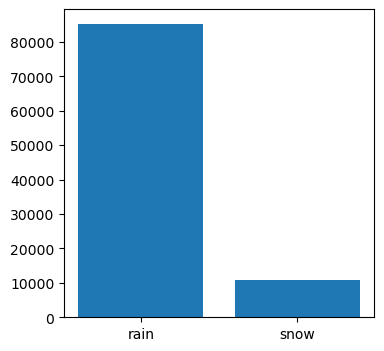

In [230]:
# Precip Type column has some missing values
# (Total entries = 96453, Non-null entries = 95936)
print(weather_dataset["Precip Type"].value_counts())

# Plotting the distribution of Precip Type
plt.figure(figsize=(4, 4))  
plt.bar(weather_dataset["Precip Type"].value_counts().index, weather_dataset["Precip Type"].value_counts().values)
plt.show()

In [231]:
# After looking at the values, it looks like the missing or null values mean neither rain nor snow
# So replacing NaN values with "None" indicating no precipitation
weather_dataset["Precip Type"] = weather_dataset["Precip Type"].fillna("None")

In [232]:
weather_dataset["Summary"].value_counts()

Summary
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Hu

<class 'pandas.core.frame.DataFrame'>
Index: 34635 entries, 46 to 96436
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            34635 non-null  object 
 1   Summary                   34635 non-null  object 
 2   Precip Type               34635 non-null  object 
 3   Temperature (C)           34635 non-null  float64
 4   Apparent Temperature (C)  34635 non-null  float64
 5   Humidity                  34635 non-null  float64
 6   Wind Speed (km/h)         34635 non-null  float64
 7   Wind Bearing (degrees)    34635 non-null  float64
 8   Visibility (km)           34635 non-null  float64
 9   Loud Cover                34635 non-null  float64
 10  Pressure (millibars)      34635 non-null  float64
dtypes: float64(8), object(3)
memory usage: 3.2+ MB
None


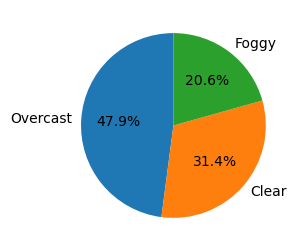

In [233]:
# For better performance of the model, we will use only three classes
selected_classes = ['Overcast', 'Clear', 'Foggy']
weather_dataset = weather_dataset[weather_dataset['Summary'].isin(selected_classes)]

print(weather_dataset.info())

# Display the distribution of the selected classes
plt.figure(figsize=(5, 3))
plt.pie(weather_dataset['Summary'].value_counts(), labels=weather_dataset['Summary'].value_counts().index, autopct='%1.1f%%', startangle=90)
plt.show()

# We selected Overcast, Clear, and Foggy as they are the most frequent and relatively balanced distinct weather conditions.


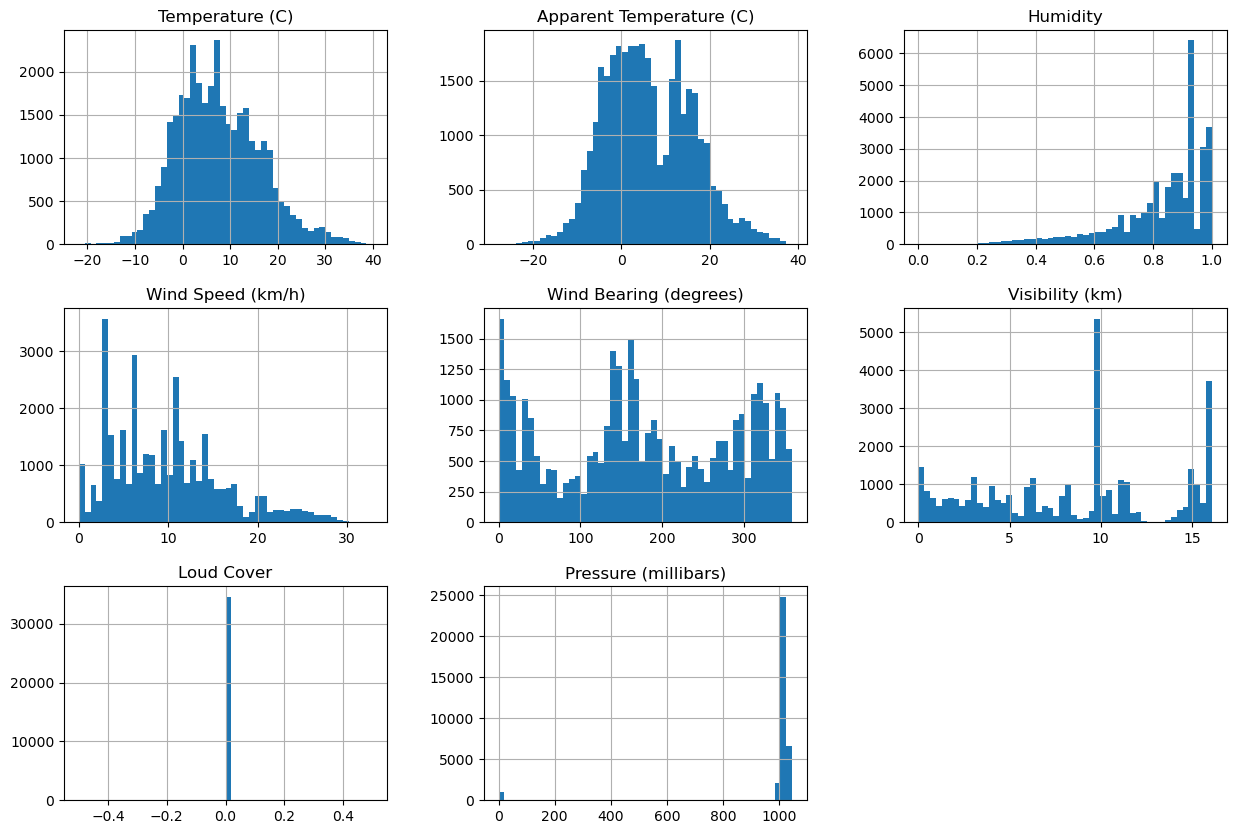

In [234]:
# Display the distribution for each attribute
%matplotlib inline
import matplotlib.pyplot as plt
weather_dataset.hist(bins=50, figsize=(15,10))
plt.show()

In [235]:
# Temperature, Apparent Temperature, and Wind Speed show roughly normal or right-skewed distributions.
# Humidity and Visibility are skewed toward higher values, indicating generally high humidity and good visibility.
# Wind Bearing appears uniformly distributed, reflecting diverse wind directions.
# Pressure and Cloud Cover are concentrated in narrow ranges, suggesting low variability and possibly limited predictive value.

# There is an issue in the dataset, the attribute "Loud Cover" should be "Cloud Cover"
# But since all the samples have the same value for cloud cover, we can drop this column
weather_dataset = weather_dataset.drop(columns=["Loud Cover"])

In [236]:
# Also, the histogram for "Pressure (millibars)" shows that there are some outliers
# (values of 0) which are not valid for pressure readings

# Count the number of zero values
zero_pressure_count = (weather_dataset['Pressure (millibars)'] == 0).sum()
print(f"Number of zero values in 'Pressure (millibars)': {zero_pressure_count}")
print(f"Percentage of zero values in 'Pressure (millibars)': {zero_pressure_count / len(weather_dataset) * 100:.2f}%")

Number of zero values in 'Pressure (millibars)': 981
Percentage of zero values in 'Pressure (millibars)': 2.83%


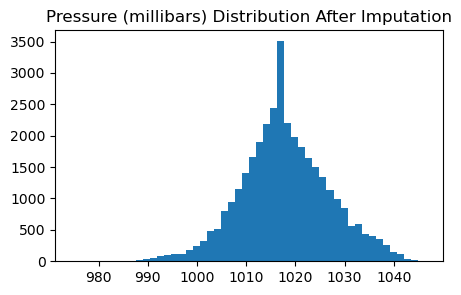

In [237]:
# Since the number of zero values is small (2.83% of the dataset), we can replace them with the median of the column
# applying data imputation technique to replace the zero values with the median of the column
weather_dataset['Pressure (millibars)'] = weather_dataset['Pressure (millibars)'].replace(0, weather_dataset['Pressure (millibars)'].median())
plt.figure(figsize=(5, 3))
plt.hist(weather_dataset['Pressure (millibars)'], bins=50)
plt.title('Pressure (millibars) Distribution After Imputation')
plt.show()

In [238]:
# Now visualitizing the relationship between time and other attributes
# Converting the "Formatted Date" column to datetime format
weather_dataset['Formatted Date'] = pd.to_datetime(weather_dataset['Formatted Date'], utc=True)


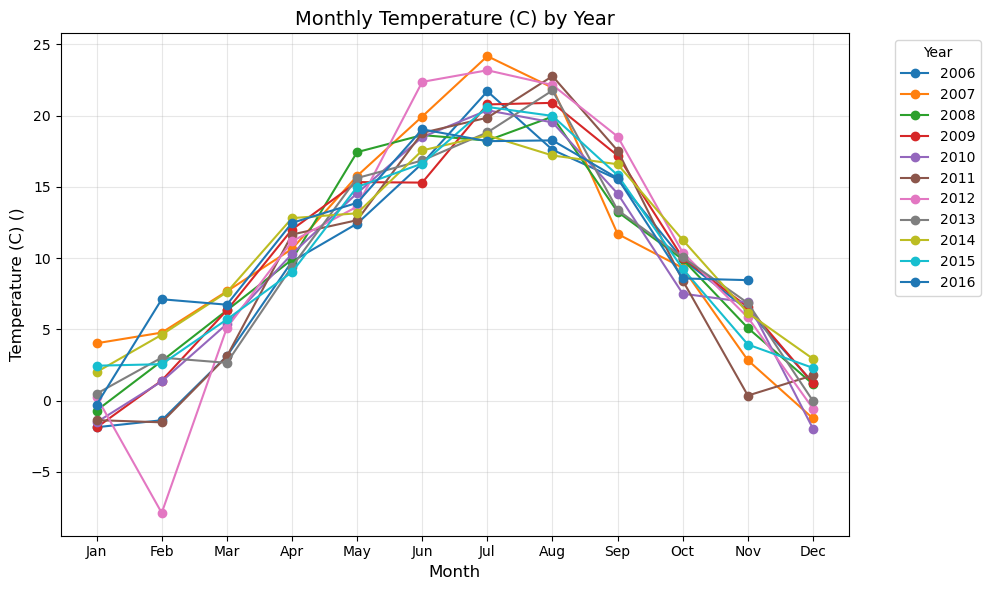

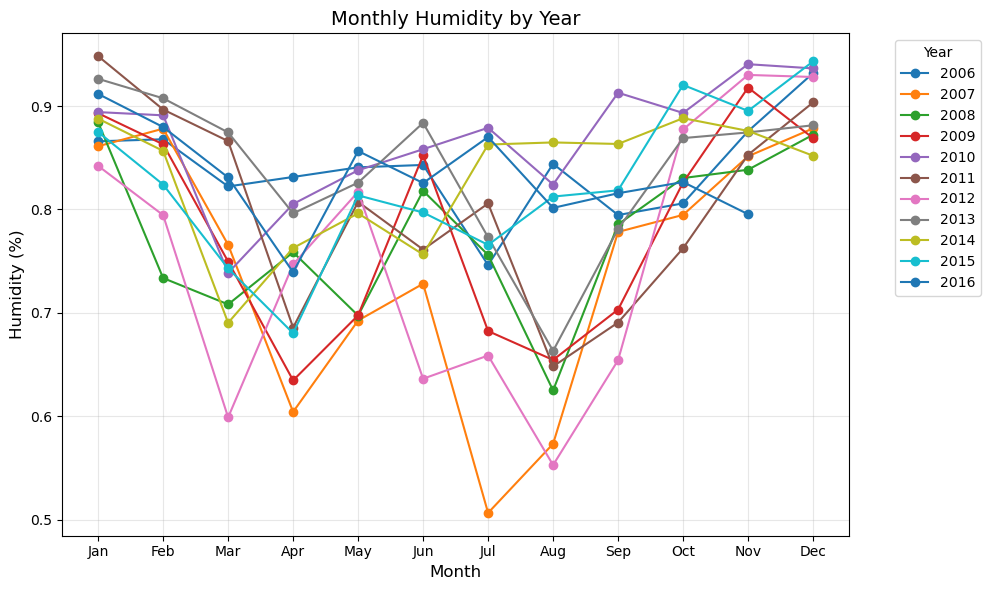

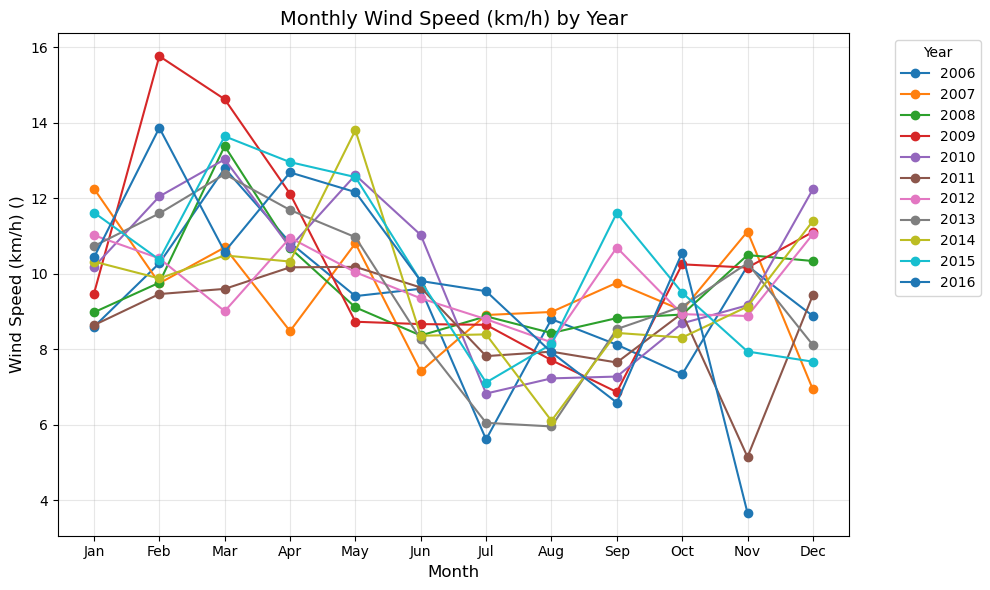

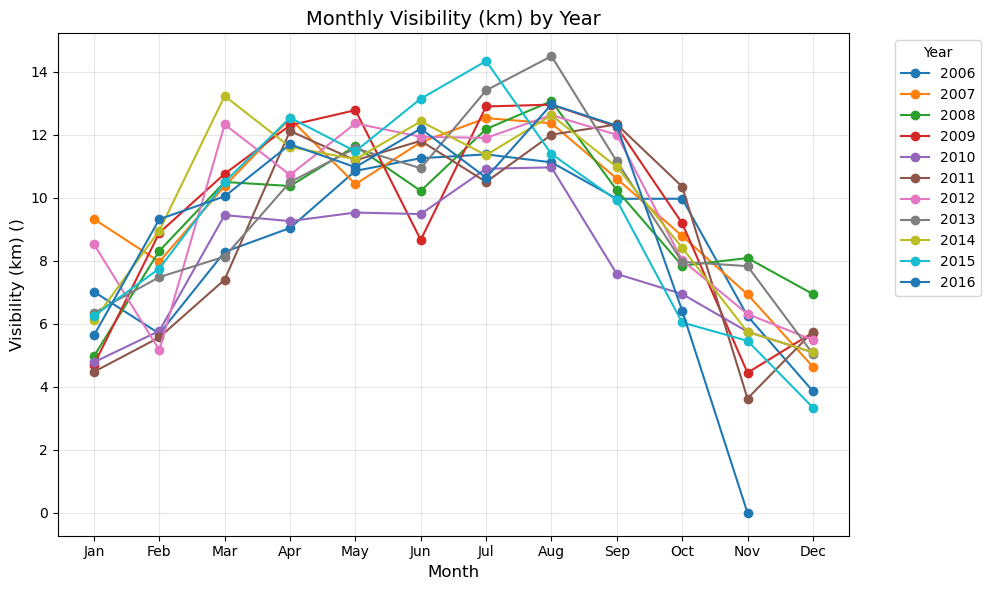

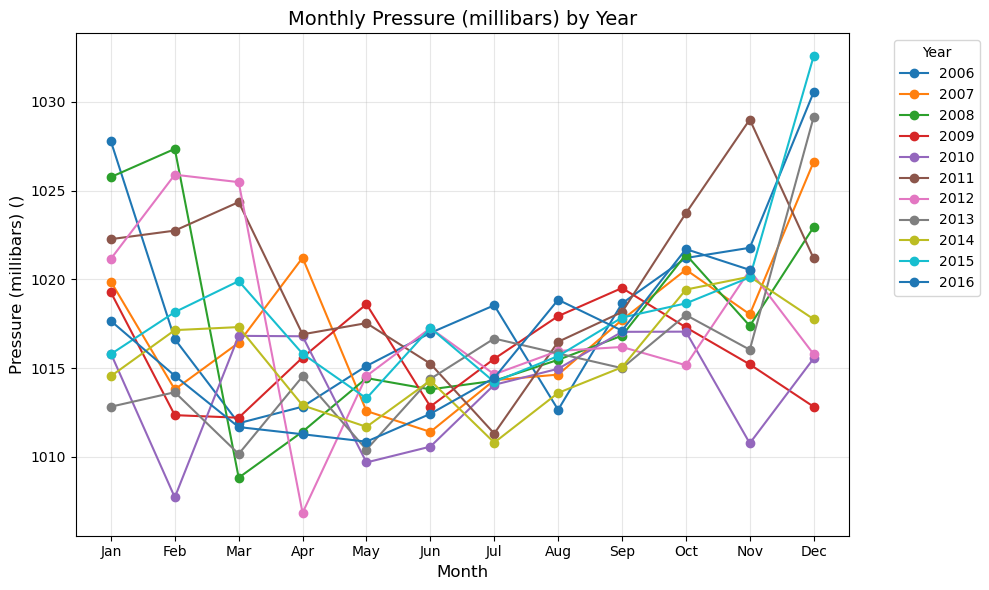

In [239]:
def plot_monthly_trends(df, attribute, unit="°C"):
    df = df.copy()

    # Extract year and month
    df['Year'] = df['Formatted Date'].dt.year
    df['Month'] = df['Formatted Date'].dt.month
    
    # Group by Year and Month, then calculate mean
    monthly_avg = df.groupby(['Year', 'Month'])[attribute].mean().unstack(level=0)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    for year in monthly_avg.columns:
        plt.plot(monthly_avg.index, monthly_avg[year], 
                marker='o', 
                linestyle='-',
                label=year)
    
    # Formatting
    plt.title(f'Monthly {attribute} by Year', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel(f'{attribute} ({unit})', fontsize=12)
    plt.xticks(range(1, 13), 
               ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(alpha=0.3)
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_monthly_trends(weather_dataset, 'Temperature (C)', unit="")
plot_monthly_trends(weather_dataset, 'Humidity', unit="%")
plot_monthly_trends(weather_dataset, 'Wind Speed (km/h)', unit="")
plot_monthly_trends(weather_dataset, 'Visibility (km)', unit="")
plot_monthly_trends(weather_dataset, 'Pressure (millibars)', unit="")


In [240]:
# These graphs show that all the attributes have seasonal patterns.
# The temperature is higher in summer (June to August) and lower in winter (December to February).
# Humidity is generally lower in summer and higher in winter.
# Wind speed shows a slight increase in winter months.
# Visibility is higher in summer and lower in winter. (fogs are more common in winter)
# Pressure is generally higher in winter and lower in summer.

# This indicates that the weather conditions are influenced by the seasons, which is important for our model.
# So we will add month and day as features to the dataset so that the model can learn these seasonal patterns.
# Not using year as it might cause overfitting.

weather_dataset['Month'] = weather_dataset['Formatted Date'].dt.month
weather_dataset['Day'] = weather_dataset['Formatted Date'].dt.day
weather_dataset = weather_dataset.drop(columns=["Formatted Date"], axis=1)


In [241]:
# Applying one hot encoding to precip type
weather_dataset = pd.get_dummies(weather_dataset, columns=["Precip Type"])

In [242]:
# Using Label Encoding for the target variable
label_encoder = LabelEncoder()
weather_dataset["Summary"] = label_encoder.fit_transform(weather_dataset["Summary"])
label_names = label_encoder.classes_

for i, label in enumerate(label_names):
    print(f"{i}: {label}")

0: Clear
1: Foggy
2: Overcast


In [243]:
# Checking for multicollinearity 
weather_dataset.corr().style.background_gradient(cmap='coolwarm')

,Summary,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Month,Day,Precip Type_None,Precip Type_rain,Precip Type_snow
Summary,1.000000,-0.184228,-0.198971,0.254529,0.290049,0.021862,-0.121083,-0.243794,-0.086064,-0.023410,-0.034014,0.002154,0.004840
Temperature (C),-0.184228,1.000000,0.988666,-0.508642,0.033614,0.016182,0.455443,-0.335744,0.158044,-0.006126,0.006851,0.631708,-0.641074
Apparent Temperature (C),-0.198971,0.988666,1.000000,-0.474652,-0.070342,0.018794,0.431105,-0.295471,0.174132,-0.001490,0.007739,0.624392,-0.633849
Humidity,0.254529,-0.508642,-0.474652,1.000000,-0.197236,0.044678,-0.490609,0.020782,0.062777,0.003901,-0.021506,-0.178647,0.185335
Wind Speed (km/h),0.290049,0.033614,-0.070342,-0.197236,1.000000,0.051535,0.166142,-0.326623,-0.122519,-0.033725,0.004508,0.082813,-0.084786
Wind Bearing (degrees),0.021862,0.016182,0.018794,0.044678,0.051535,1.000000,0.034000,-0.066771,-0.006724,-0.009295,0.001564,0.028099,-0.028776
Visibility (km),-0.121083,0.455443,0.431105,-0.490609,0.166142,0.034000,1.000000,-0.185986,-0.089304,-0.043701,-0.051491,0.325526,-0.318994
Pressure (millibars),-0.243794,-0.335744,-0.295471,0.020782,-0.326623,-0.066771,-0.185986,1.000000,0.162853,0.066868,0.030655,-0.336004,0.333906
Month,-0.086064,0.158044,0.174132,0.062777,-0.122519,-0.006724,-0.089304,0.162853,1.000000,0.065719,0.055881,0.140014,-0.153312
Day,-0.023410,-0.006126,-0.001490,0.003901,-0.033725,-0.009295,-0.043701,0.066868,0.065719,1.000000,0.056576,-0.030419,0.019123


In [244]:
# Since the correlation between "Temperature (C)" and "Apparent Temperature (C)" is very high (0.98), we will drop one of them.
weather_dataset = weather_dataset.drop(["Apparent Temperature (C)"], axis=1)

In [245]:
X = weather_dataset.drop(["Summary"], axis=1)
y = weather_dataset["Summary"]

final_columns = X.columns.tolist()

In [246]:
# applying standardization to the features
standard_scaler = StandardScaler()
columns_to_standardize = ["Temperature (C)", "Wind Speed (km/h)", "Pressure (millibars)", "Humidity", "Visibility (km)", "Wind Bearing (degrees)", "Day", "Month"]
X[columns_to_standardize] = standard_scaler.fit_transform(X[columns_to_standardize])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify to maintain the class distribution in train and test sets

# Non-Parametric Models

## 1. kNN

### Grid Search Results

param_metric,param_n_neighbors,mean_test_score,std_test_score
manhattan,1,0.889418,0.003967
manhattan,3,0.883752,0.002879
manhattan,5,0.875559,0.002154
euclidean,1,0.869207,0.006621
manhattan,2,0.865562,0.002182
euclidean,3,0.860690,0.003624
euclidean,5,0.851342,0.003207
euclidean,2,0.845063,0.003933


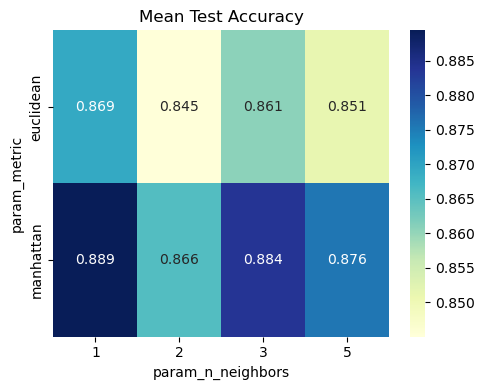

### Best Model Parameters

Attribute,Value
metric,manhattan
n_neighbors,1
mean_test_score,0.8894


### Classification Report

,precision,recall,f1-score,support
Clear,0.899,0.878,0.889,2178.000
Foggy,0.888,0.917,0.902,1430.000
Overcast,0.903,0.904,0.904,3319.000
accuracy,0.899,0.899,0.899,0.899
macro avg,0.897,0.900,0.898,6927.000
weighted avg,0.899,0.899,0.899,6927.000


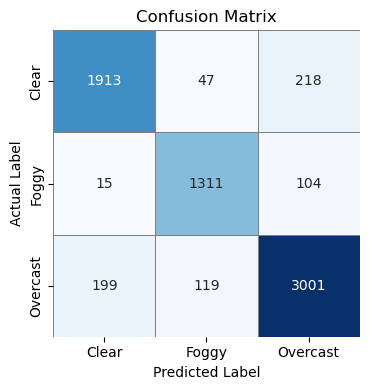

### Accuracy on Test Set: `0.8987`

In [247]:
from sklearn.neighbors import KNeighborsClassifier

# Using stratified k-fold cross-validation as the dataset is not perfectly balanced
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_neighbors': [1, 2, 3, 5],
    'metric': ['euclidean', 'manhattan']
}

# Applying Grid Search to find the best hyperparameters
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=skf,
                    scoring='accuracy', n_jobs=-1, return_train_score=True)
knn.fit(X_train, y_train)

# Display results
display_grid_search_results(knn, X_test, y_test, label_names)

In [248]:
results.append({
    'Model': 'KNN',
    'Train Accuracy': accuracy_score(y_train, knn.predict(X_train)),
    'Test Accuracy': accuracy_score(y_test, knn.predict(X_test)),
    'Precision': precision_score(y_test, knn.predict(X_test), average='weighted'),
    'Recall': recall_score(y_test, knn.predict(X_test), average='weighted'),
    'F1-Score': f1_score(y_test, knn.predict(X_test), average='weighted')
})

In [249]:
predict_weather(knn)

## 2. Decision Tree

### Grid Search Results

param_criterion,param_max_depth,mean_test_score,std_test_score
entropy,20,0.870723,0.006002
gini,20,0.867908,0.003942
gini,15,0.865887,0.005372
entropy,15,0.864985,0.005259
gini,10,0.855168,0.005359
entropy,10,0.846579,0.005088


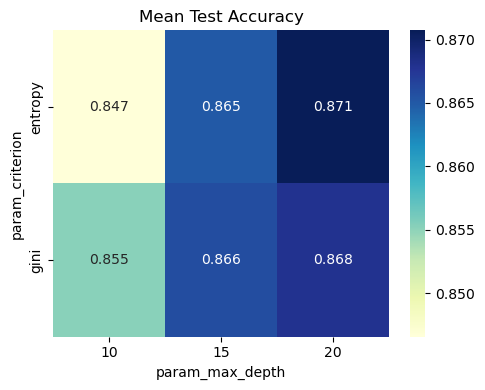

### Best Model Parameters

Attribute,Value
criterion,entropy
max_depth,20
mean_test_score,0.8707


### Classification Report

,precision,recall,f1-score,support
Clear,0.810,0.816,0.813,2178.000
Foggy,0.999,0.999,0.999,1430.000
Overcast,0.879,0.875,0.877,3319.000
accuracy,0.882,0.882,0.882,0.882
macro avg,0.896,0.896,0.896,6927.000
weighted avg,0.882,0.882,0.882,6927.000


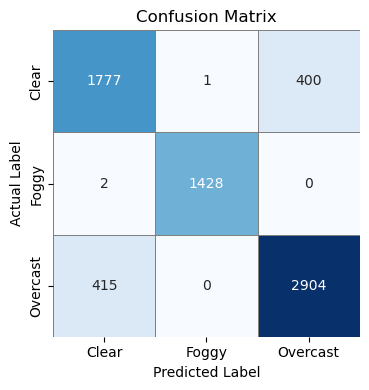

### Accuracy on Test Set: `0.8819`

In [250]:
from sklearn.tree import DecisionTreeClassifier

# Using stratified k-fold cross-validation as the dataset is not perfectly balanced
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 20],                   
}

# Using Grid Search to find the best combination of hyperparameters
dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=skf, scoring='accuracy')
dt.fit(X_train, y_train)

# Display results
display_grid_search_results(dt, X_test, y_test, label_names)

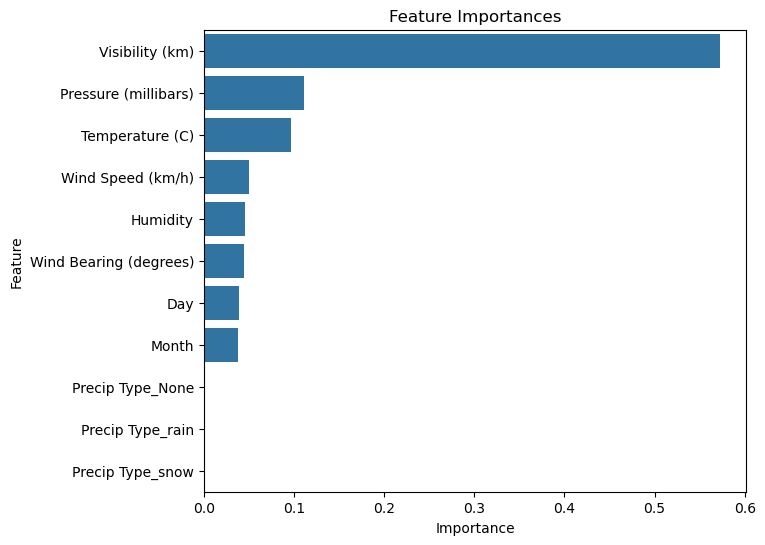

In [251]:
# display the importance of each feature according to the best decision tree model
importances = dt.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importances = pd.DataFrame({'Feature': X.columns[indices], 'Importance': importances[indices]})
plt.figure(figsize=(7, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

In [252]:
# We can see the decision tree has given the highest importnace to visiblity as it is useful to differentiate between foggy, clear and overcast weather

In [253]:
results.append({
    'Model': 'Decision Tree',
    'Train Accuracy': accuracy_score(y_train, dt.predict(X_train)),
    'Test Accuracy': accuracy_score(y_test, dt.predict(X_test)),
    'Precision': precision_score(y_test, dt.predict(X_test), average='weighted'),
    'Recall': recall_score(y_test, dt.predict(X_test), average='weighted'),
    'F1-Score': f1_score(y_test, dt.predict(X_test), average='weighted')
})

In [254]:
# making a new preprocess function for the decision tree as it doesn't need scaling
def preprocess_user_input_dt(df):
    df = pd.get_dummies(df, columns=['Precip Type'])
    
    for col in final_columns:
        if col not in df.columns:
            df[col] = 0
            
    df = df[final_columns]    
    return df

# Predict weather using the Decision Tree model
predict_weather(dt, preprocess_fn=preprocess_user_input_dt)

## 3. SVM

### Grid Search Results

param_C,param_gamma,mean_test_score,std_test_score
10,scale,0.879493,0.001007
10,0.100000,0.876786,0.000914
1,scale,0.859427,0.001652
1,0.100000,0.858272,0.001514


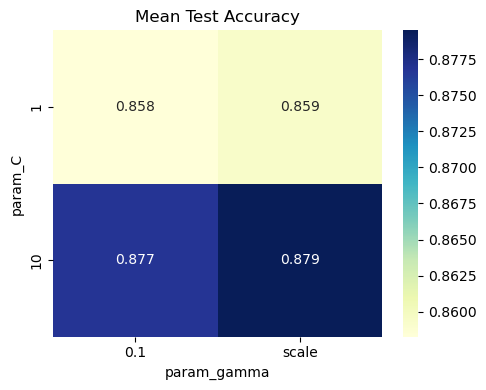

### Best Model Parameters

Attribute,Value
C,10
gamma,scale
mean_test_score,0.8795


### Classification Report

,precision,recall,f1-score,support
Clear,0.823,0.765,0.793,2178.000
Foggy,0.976,0.993,0.984,1430.000
Overcast,0.856,0.889,0.872,3319.000
accuracy,0.871,0.871,0.871,0.871
macro avg,0.885,0.882,0.883,6927.000
weighted avg,0.870,0.871,0.870,6927.000


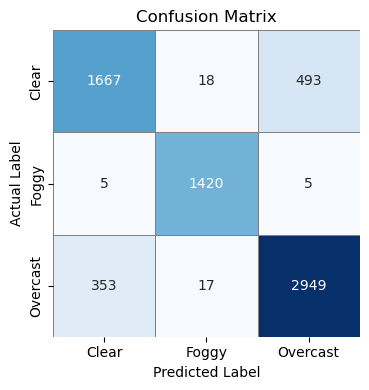

### Accuracy on Test Set: `0.8714`

In [255]:
from sklearn.svm import SVC

# Using stratified k-fold cross-validation as the dataset is not perfectly balanced
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [1, 10],          
    'gamma': ['scale', 0.1]
}

    
# Using Grid Search to find the best combination of hyperparameters
# Using ovr (one-vs-rest) as the decision function shape for multiclass classification
# Using rbf kernel so that the model can learn non-linear decision boundaries
# SVM with rbf kernel is non-parametric
svm = GridSearchCV(SVC(random_state=42, decision_function_shape='ovr', kernel="rbf") , param_grid, cv=skf, scoring='accuracy')
svm.fit(X_train, y_train)

# Display results
display_grid_search_results(svm, X_test, y_test, label_names)


In [256]:
results.append({
    'Model': 'SVM',
    'Train Accuracy': accuracy_score(y_train, svm.predict(X_train)),
    'Test Accuracy': accuracy_score(y_test, svm.predict(X_test)),
    'Precision': precision_score(y_test, svm.predict(X_test), average='weighted'),
    'Recall': recall_score(y_test, svm.predict(X_test), average='weighted'),
    'F1-Score': f1_score(y_test, svm.predict(X_test), average='weighted')
})

In [257]:
predict_weather(svm)

# Parametric Models

## 1. Logistic Regression

### Grid Search Results

param_C,mean_test_score,std_test_score
1000,0.782806,0.006760
100,0.782770,0.006790
10,0.782446,0.006602
1,0.781543,0.006513
0.100000,0.776888,0.006785


### Best Model Parameters

Attribute,Value
C,1000
mean_test_score,0.7828


### Classification Report

,precision,recall,f1-score,support
Clear,0.682,0.638,0.659,2178.00
Foggy,0.908,0.941,0.924,1430.00
Overcast,0.764,0.784,0.774,3319.00
accuracy,0.770,0.770,0.770,0.77
macro avg,0.784,0.788,0.786,6927.00
weighted avg,0.768,0.770,0.769,6927.00


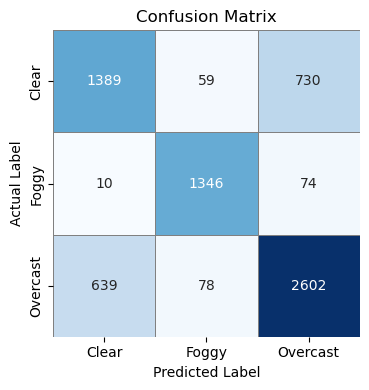

### Accuracy on Test Set: `0.7705`

In [258]:
# import logistic regression
from sklearn.linear_model import LogisticRegression

# Using stratified k-fold cross-validation as the dataset is not perfectly balanced
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 1000]
}

# Using Grid Search to find the best combination of hyperparameters
lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'),
    param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

lr.fit(X_train, y_train)

# Display results
display_grid_search_results(lr, X_test, y_test, label_names)


In [259]:
# Low accuracy and low precision and recall for the clear and overcast classes
# suggest that the data might not be linearly separable as there might be some overlap in clear and overcast classes
# the model is not able to distinguish between clear and overcast weather   

In [260]:
# Viewing the weights assigned to each feature
weights = lr.best_estimator_.coef_[0]

# Create DataFrame with additional columns
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Weight': weights,
    'Absolute Weight': np.abs(weights),  # For ranking importance
    'Direction': np.where(weights < 0, 'Negative', 'Positive')  # Sign indicator
})

# Sort by absolute weight (most important features first)
feature_importances = feature_importances.sort_values(by='Absolute Weight', ascending=False)

display(Markdown("### Feature Importance (Ranked by Absolute Weight)"))
display(feature_importances[['Feature', 'Weight', 'Direction', 'Absolute Weight']]
        .style.hide(axis="index")
        .format({'Weight': "{:.3f}", 'Absolute Weight': "{:.3f}"}))

### Feature Importance (Ranked by Absolute Weight)

Feature,Weight,Direction,Absolute Weight
Visibility (km),0.987,Positive,0.987
Precip Type_None,0.863,Positive,0.863
Precip Type_rain,-0.843,Negative,0.843
Wind Speed (km/h),-0.717,Negative,0.717
Pressure (millibars),0.668,Positive,0.668
Humidity,-0.666,Negative,0.666
Temperature (C),0.482,Positive,0.482
Precip Type_snow,-0.481,Negative,0.481
Wind Bearing (degrees),0.101,Positive,0.101
Month,0.082,Positive,0.082


In [261]:
results.append({
    'Model': 'Logistic Regression',
    'Train Accuracy': accuracy_score(y_train, lr.predict(X_train)),
    'Test Accuracy': accuracy_score(y_test, lr.predict(X_test)),
    ''
    'Precision': precision_score(y_test, lr.predict(X_test), average='weighted'),
    'Recall': recall_score(y_test, lr.predict(X_test), average='weighted'),
    'F1-Score': f1_score(y_test, lr.predict(X_test), average='weighted')
})

In [262]:
# this shows that the model is giving more importance to visibility
# but somehow it has also assigned higher weight to precip type none
predict_weather(lr)

# Neural Network

c:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### NeuralNet1 — `[64]`, `relu`, Batch `32`

### Classification Report

,precision,recall,f1-score,support
Clear,0.796,0.782,0.789,2178.000
Foggy,0.991,0.997,0.994,1430.000
Overcast,0.859,0.867,0.863,3319.000
accuracy,0.867,0.867,0.867,0.867
macro avg,0.882,0.882,0.882,6927.000
weighted avg,0.867,0.867,0.867,6927.000


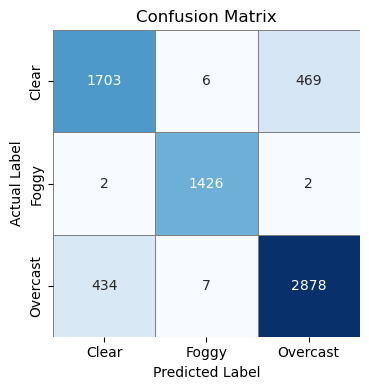

### Accuracy on Test Set: `0.8672`

c:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### NeuralNet2 — `[32, 16]`, `tanh`, Batch `64`

### Classification Report

,precision,recall,f1-score,support
Clear,0.809,0.787,0.798,2178.000
Foggy,0.994,0.991,0.993,1430.000
Overcast,0.862,0.879,0.870,3319.000
accuracy,0.873,0.873,0.873,0.873
macro avg,0.888,0.885,0.887,6927.000
weighted avg,0.873,0.873,0.873,6927.000


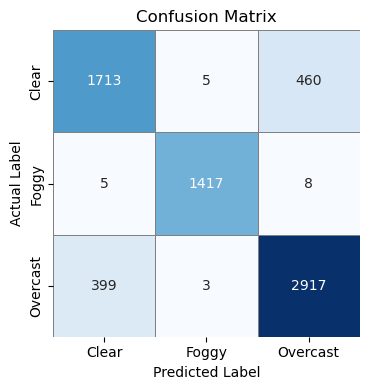

### Accuracy on Test Set: `0.8730`

c:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### NeuralNet3 — `[64, 32, 16, 8]`, `relu`, Batch `40`

### Classification Report

,precision,recall,f1-score,support
Clear,0.792,0.840,0.815,2178.000
Foggy,0.984,0.990,0.987,1430.000
Overcast,0.890,0.853,0.871,3319.000
accuracy,0.877,0.877,0.877,0.877
macro avg,0.889,0.894,0.891,6927.000
weighted avg,0.879,0.877,0.877,6927.000


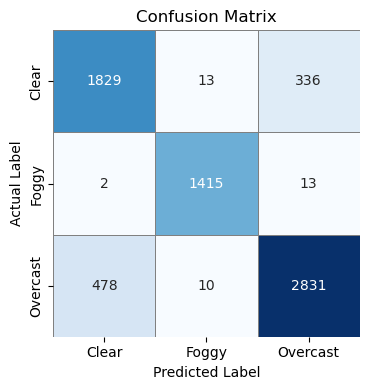

### Accuracy on Test Set: `0.8770`

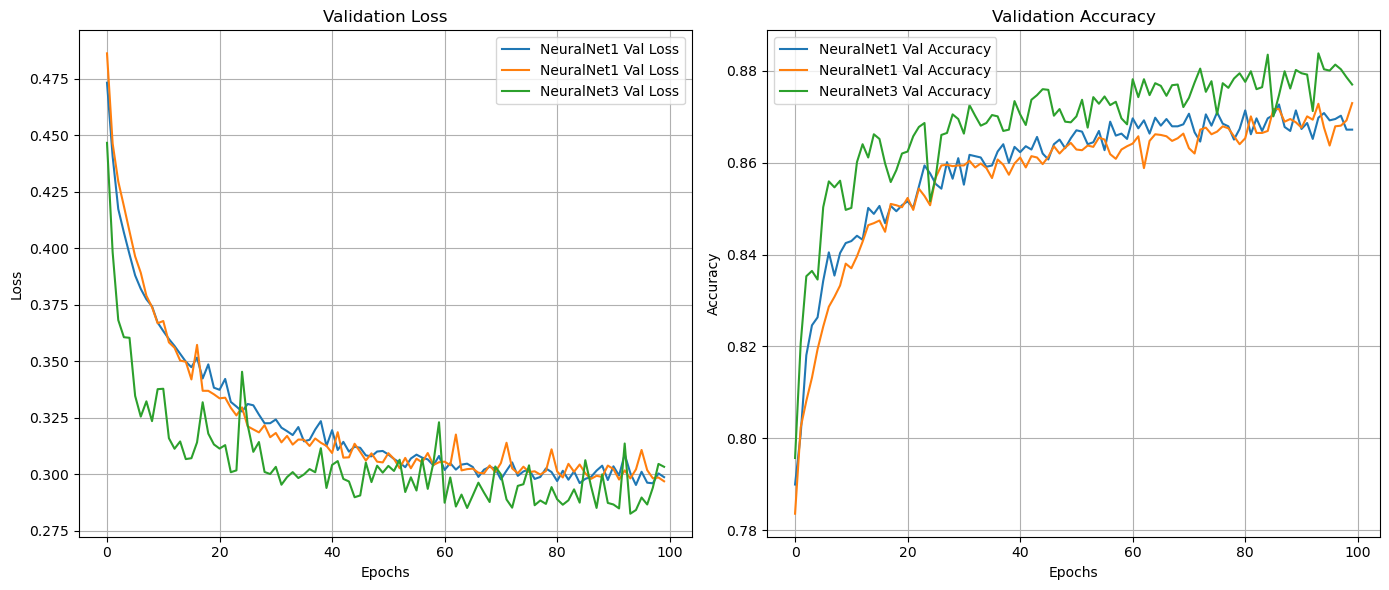

In [263]:
from keras.models import Sequential
from keras import layers

# define the training function
def train_model(hidden_layers, activation, batch_size, model_name, epochs=100):
    model = Sequential()
    model.add(layers.Dense(hidden_layers[0], activation=activation, input_shape=(X_train.shape[1],)))
    for units in hidden_layers[1:]:
        model.add(layers.Dense(units, activation=activation))
    model.add(layers.Dense(3, activation='softmax'))

    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Display results
    display(Markdown(f"### {model_name} — `{hidden_layers}`, `{activation}`, Batch `{batch_size}`"))

    # Classification Report
    report_dict = classification_report(y_test, y_pred, output_dict=True, target_names=label_names)
    report_df = pd.DataFrame(report_dict).transpose().round(3)
    display(Markdown("### Classification Report"))
    display(report_df)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=label_names, yticklabels=label_names,
                linewidths=0.5, linecolor='gray', square=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.tight_layout()
    plt.show()

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    display(Markdown(f"### Accuracy on Test Set: `{acc:.4f}`"))

    return model, history


# Plot training history comparison
def plot_history(histories, labels):
    plt.figure(figsize=(14, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label} Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Train models
nn1, history1 = train_model(hidden_layers=[64], activation='relu', batch_size=32, model_name='NeuralNet1')
nn2, history2 = train_model(hidden_layers=[32, 16], activation='tanh', batch_size=64, model_name='NeuralNet2')
nn3, history3 = train_model(hidden_layers=[64, 32, 16, 8], activation='relu', batch_size=40, model_name='NeuralNet3')

# Compare all models' training curves
plot_history(
    [history1, history2, history3],
    ['NeuralNet1', 'NeuralNet1', 'NeuralNet3']
)


In [264]:
results.append({
    'Model': 'NeuralNet1',
    'Train Accuracy': accuracy_score(y_train, nn1.predict(X_train).argmax(axis=1)),
    'Test Accuracy': accuracy_score(y_test, nn1.predict(X_test).argmax(axis=1)),
    'Precision': precision_score(y_test, nn1.predict(X_test).argmax(axis=1), average='weighted'),
    'Recall': recall_score(y_test, nn1.predict(X_test).argmax(axis=1), average='weighted'),
    'F1-Score': f1_score(y_test, nn1.predict(X_test).argmax(axis=1), average='weighted')
})

results.append({
    'Model': 'NeuralNet2',
    'Train Accuracy': accuracy_score(y_train, nn2.predict(X_train).argmax(axis=1)),
    'Test Accuracy': accuracy_score(y_test, nn2.predict(X_test).argmax(axis=1)),
    'Precision': precision_score(y_test, nn2.predict(X_test).argmax(axis=1), average='weighted'),
    'Recall': recall_score(y_test, nn2.predict(X_test).argmax(axis=1), average='weighted'),
    'F1-Score': f1_score(y_test, nn2.predict(X_test).argmax(axis=1), average='weighted')
})

results.append({
    'Model': 'NeuralNet3',
    'Train Accuracy': accuracy_score(y_train, nn3.predict(X_train).argmax(axis=1)),
    'Test Accuracy': accuracy_score(y_test, nn3.predict(X_test).argmax(axis=1)),
    'Precision': precision_score(y_test, nn3.predict(X_test).argmax(axis=1), average='weighted'),
    'Recall': recall_score(y_test, nn3.predict(X_test).argmax(axis=1), average='weighted'),
    'F1-Score': f1_score(y_test, nn3.predict(X_test).argmax(axis=1), average='weighted')
})

866/866 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
866/866 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
866/866 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [268]:
tab1_out = widgets.Output()
tab2_out = widgets.Output()
tab3_out = widgets.Output()

with tab1_out:
	predict_weather(nn1)
with tab2_out:
	predict_weather(nn2)
with tab3_out:
	predict_weather(nn3)

tabs = widgets.Tab(children=[tab1_out, tab2_out, tab3_out])
tabs.set_title(0, 'Model 1')
tabs.set_title(1, 'Model 2')
tabs.set_title(2, 'Model 3')

# Display the tabs
display(tabs)

# Comparing The Models

### Model Evaluation Results

Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Accuracy Diff
KNN,1.000,0.899,0.899,0.899,0.899,0.101
Decision Tree,0.987,0.882,0.882,0.882,0.882,0.105
SVM,0.896,0.871,0.870,0.871,0.870,0.024
Logistic Regression,0.783,0.770,0.768,0.770,0.769,0.012
NeuralNet1,0.886,0.867,0.867,0.867,0.867,0.019
NeuralNet2,0.890,0.873,0.873,0.873,0.873,0.017
NeuralNet3,0.913,0.877,0.879,0.877,0.877,0.036


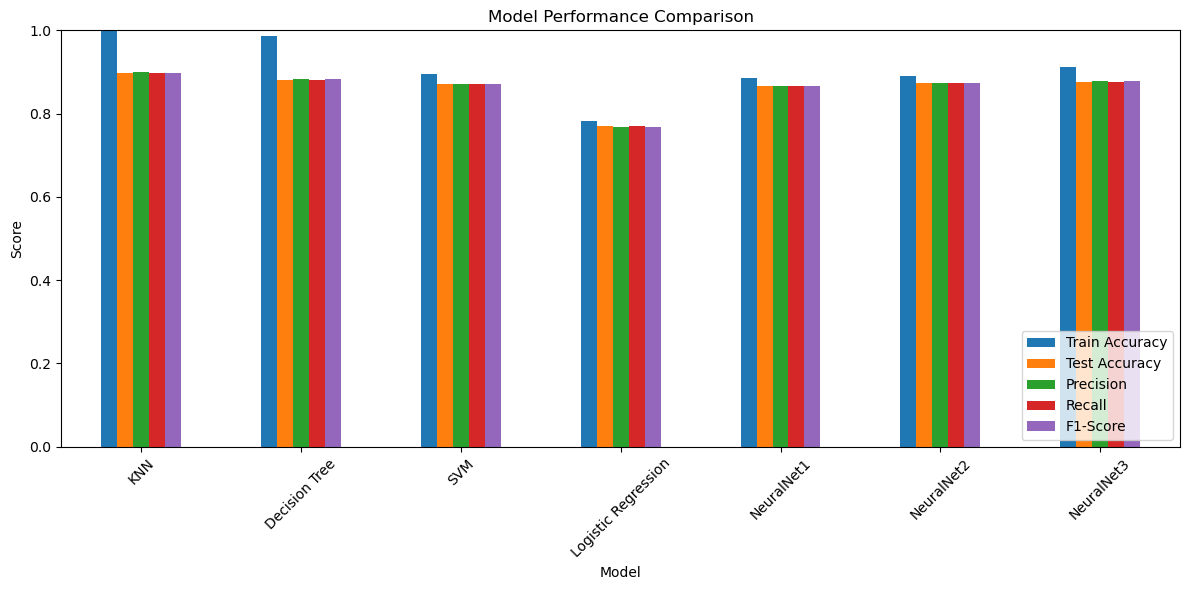

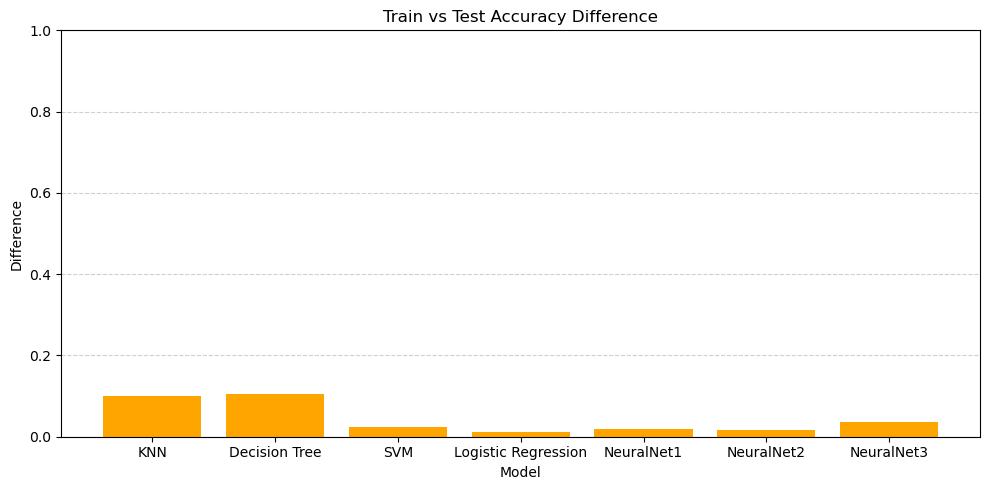

In [266]:
# Convert to DataFrame
df_results = pd.DataFrame(results)
df_results['Accuracy Diff'] = df_results['Train Accuracy'] - df_results['Test Accuracy']
display(Markdown("### Model Evaluation Results"))
display(df_results.style.hide(axis="index").format({
    'Train Accuracy': "{:.3f}",
    'Test Accuracy': "{:.3f}",
    'Accuracy Diff': "{:.3f}",
    'Precision': "{:.3f}",
    'Recall': "{:.3f}",
    'F1-Score': "{:.3f}"
}))

# Bar plot for model performance comparison
metrics = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score']
df_plot = df_results.set_index('Model')[metrics]

df_plot.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Graphing the difference between train and test accuracy
plt.figure(figsize=(10, 5))
plt.bar(df_results['Model'], df_results['Train Accuracy'] - df_results['Test Accuracy'], color='orange')
plt.title("Train vs Test Accuracy Difference")
plt.ylabel("Difference")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
# This show that kNN, Decision Tree models are overfitting the data
# kNN is overfitting because k is set to 1, we can increase the value of k to reduce overfitting
# Decision Tree is overfitting because it is too deep, we have tried limiting the depth but at small depth it is not performing well so we have to find a right balance
# Logistic regression is underfitting the data as it is not able to learn the complex patterns in the data
# Neural networks and SVM have the highest performance as they are able to learn complex patterns in the data and they are not overfitting

# Effect of Changing The Data Split Ratio

In [ ]:
# A larger training set improved learning but reduced evaluation reliability.
# A larger test set gives more reliable evaluation but can lead to underfitting due to limited training data.